In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import nltk
import re
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
import emoji

# Загрузим датасет

In [3]:
df_train = pd.read_csv("/kaggle/input/vk-spam/spam_dataset/train_spam.csv")
df_test = pd.read_csv("/kaggle/input/vk-spam/spam_dataset/test_spam.csv")

### Проверим на пропуски

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16278 non-null  object
 1   text       16278 non-null  object
dtypes: object(2)
memory usage: 254.5+ KB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4070 entries, 0 to 4069
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4070 non-null   object
dtypes: object(1)
memory usage: 31.9+ KB


### Проверим трейн на дубликаты

In [6]:
df_train[df_train.duplicated(subset="text")]

,text_type,text
4145,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
4463,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
5640,ham,/ban
6933,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
7663,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
7918,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
9790,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
10290,ham,SPAM DETECTION User: Username: @DillyBubb...
10811,ham,SPAM DETECTION User: Username: @DillyBubb...
13210,ham,SPAM DETECTION User: Username: @DillyBubb...


### Дубликаты с одинаковыми метками, удалим все кроме первых

In [7]:
df_train.drop_duplicates(subset="text", keep='first', inplace=True, ignore_index=True)

### Найдём отличителные признаки в спаме

In [8]:
df_train.text[df_train.text_type=='spam'].sample(10)

12615    want explicit sex in 30 secs ring 02073162414 ...
12057    i never believe i will make so much money in f...
16158    company with lots of features reliable trusted...
1412     first payment first payment first payment firs...
12506    are you ready to get it hello viagra is the 1 ...
12402    rgent this is the 2nd attempt to contact uu ha...
13657    any one intrested in virtual open minded frien...
13395    anyone want to buy pro id in only 300 rs dm me...
2341     remove ur car scratches within minute! with ma...
3269     n b new link for coinsbit airdrop account veri...
Name: text, dtype: object

In [9]:
df_train.loc[9532].text

'𝙄𝙢 𝙨𝙤𝙧𝙧𝙮 𝙎𝙞𝙧 𝙛𝙤𝙧 𝙙𝙤𝙪𝙗𝙩𝙞𝙣𝙜 𝙮𝙤𝙪 𝙖𝙩 𝙛𝙞𝙧𝙨𝙩 𝙄 𝙧𝙚𝙖𝙡𝙡𝙮 𝙩𝙝𝙖𝙣𝙠 𝙮𝙤𝙪 𝙛𝙤𝙧 𝙮𝙤𝙪𝙧 𝙩𝙧𝙖𝙙𝙚 𝙖𝙣𝙙 𝙩𝙝𝙚 𝙥𝙧𝙤𝙛𝙞𝙩 𝙄 𝙧𝙚𝙘𝙚𝙞𝙫𝙚𝙙 𝘽𝙚𝙡𝙞𝙚𝙫𝙚𝙙 𝙢𝙚 𝙄 𝙩𝙧𝙪𝙨𝙩 𝙮𝙤𝙪 𝙬𝙞𝙩𝙝 𝙖𝙡𝙡 𝙢𝙮 𝙝𝙚𝙖𝙧𝙩𝙄𝙡𝙡 𝙩𝙤𝙡𝙙 𝙢𝙖𝙣𝙮 𝙥𝙚𝙤𝙥𝙡𝙚 𝙖𝙗𝙤𝙪𝙩 𝙮𝙤𝙪 𝙨𝙞𝙧 𝙩𝙧𝙖𝙙𝙚 𝙛𝙤𝙧 𝙩𝙝𝙚𝙢 𝙩𝙝𝙚 𝙬𝙖𝙮 𝙮𝙤𝙪 𝙩𝙧𝙖𝙙𝙚 𝙛𝙤𝙧 𝙢𝙚 𝙏𝙝𝙖𝙣𝙠 𝙨𝙞𝙧 𝙛𝙤𝙧 𝙜𝙤𝙤𝙙 𝙬𝙤𝙧𝙠 👇👍'

### Иногда текст в спаме находится в станной кодировке, поэтому стоит проверить есть ли там хотя бы одна буква в нормальной кодировке

In [10]:
def is_strange(text):
    normal_letter = re.search("[a-zA-Z]",text)
    return not normal_letter

In [11]:
is_strange(df_train.loc[9532].text), is_strange("normal text")

(True, False)

### А также в спаме подозрительно часто встречаются эмодзи

In [12]:
emoji.emoji_count(df_train.loc[9532].text)

2

### Добавим информацию, которая может пригодиться при обучении

In [13]:
df_train["len_in_chars"] = df_train.text.map(len)
df_train["len_in_words"] = df_train.text.map(lambda x: len(nltk.word_tokenize(x)))
df_train["digit_count"] = df_train.text.map(lambda x: len(re.sub("[^0-9]", "", x)))
df_train["emoji_count"] = df_train.text.map(emoji.emoji_count)
df_train["strange_format"] = df_train.text.map(is_strange)

### Переведём spam и ham в 0 и 1 соотвественно

In [14]:
le = LabelEncoder()
df_train.text_type = le.fit_transform(df_train.text_type)
le.inverse_transform([0,1])

array(['ham', 'spam'], dtype=object)

# Exploratory Data Analysis

### Изучим распределение классов

<Axes: ylabel='count'>

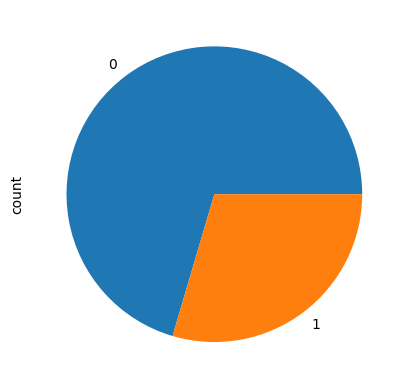

In [15]:
df_train.text_type.value_counts().plot(kind='pie')

### Присутстсвует дисбаланс классов, поэтому не стоит использовать метрику "accuracy"
### Изучим длину посимвольно и по словам

<Axes: xlabel='len_in_chars', ylabel='Count'>

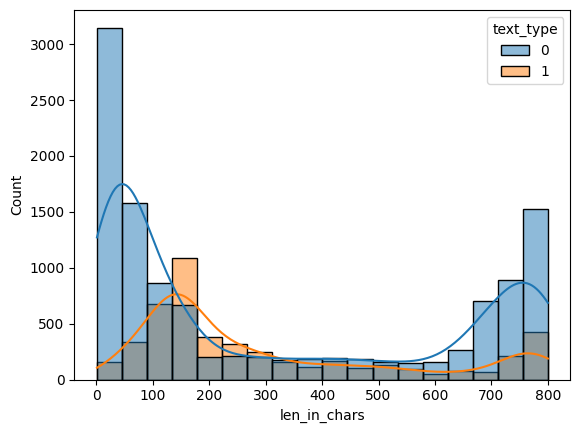

In [16]:
sns.histplot(data=df_train, x="len_in_chars", hue="text_type", kde=True)

<Axes: xlabel='len_in_words', ylabel='Count'>

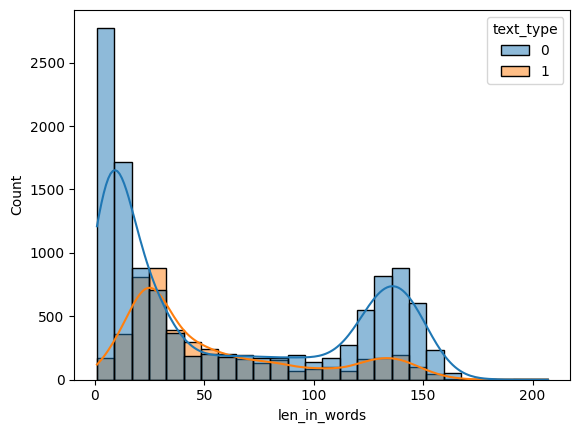

In [17]:
sns.histplot(data=df_train, x="len_in_words", hue="text_type", kde=True)

### Количество цифр

<Axes: xlabel='digit_count', ylabel='Count'>

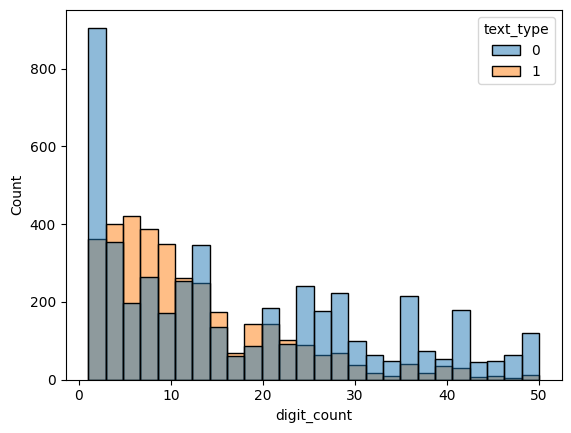

In [18]:
sns.histplot(data=df_train, x="digit_count", hue="text_type",binrange=(1,50))

### Количество эмодзи

<Axes: xlabel='emoji_count', ylabel='Count'>

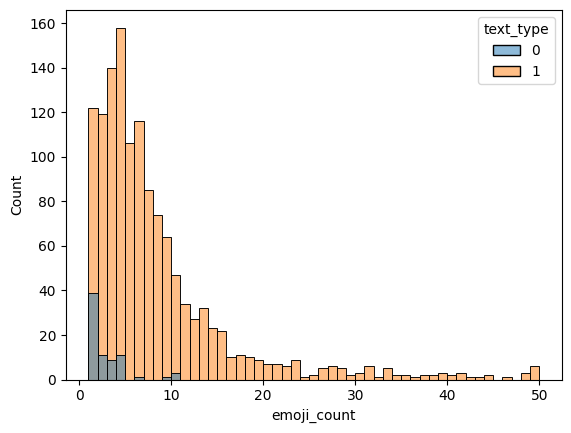

In [19]:
sns.histplot(data=df_train, x="emoji_count", hue="text_type",binwidth=1,binrange=(1,50))

# Доля "странного" форматирования

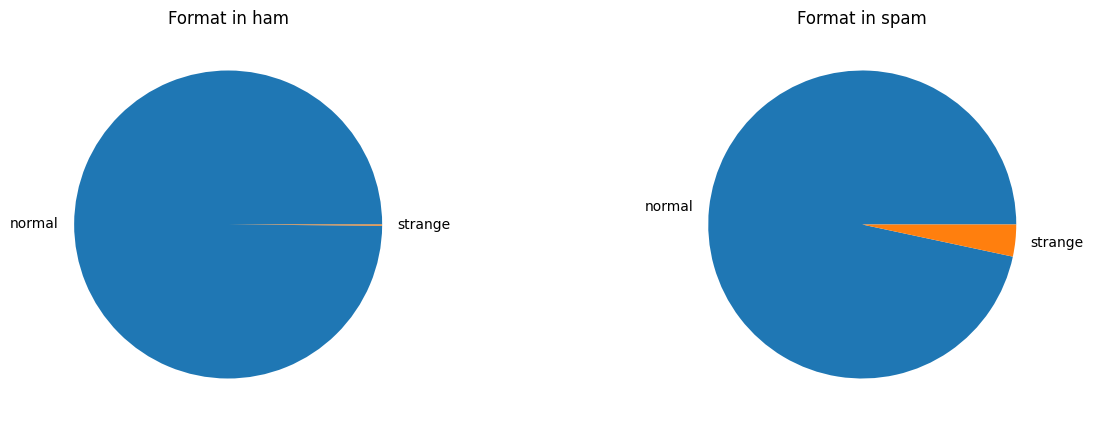

In [20]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.set_title("Format in ham")
ax1.pie(df_train[df_train.text_type == 0].strange_format.value_counts(),labels=["normal","strange"])
ax2.set_title("Format in spam")
ax2.pie(df_train[df_train.text_type == 1].strange_format.value_counts(),labels=["normal","strange"])
fig.show()

### Посмотрим можно ли визуально отделить один класс от другого

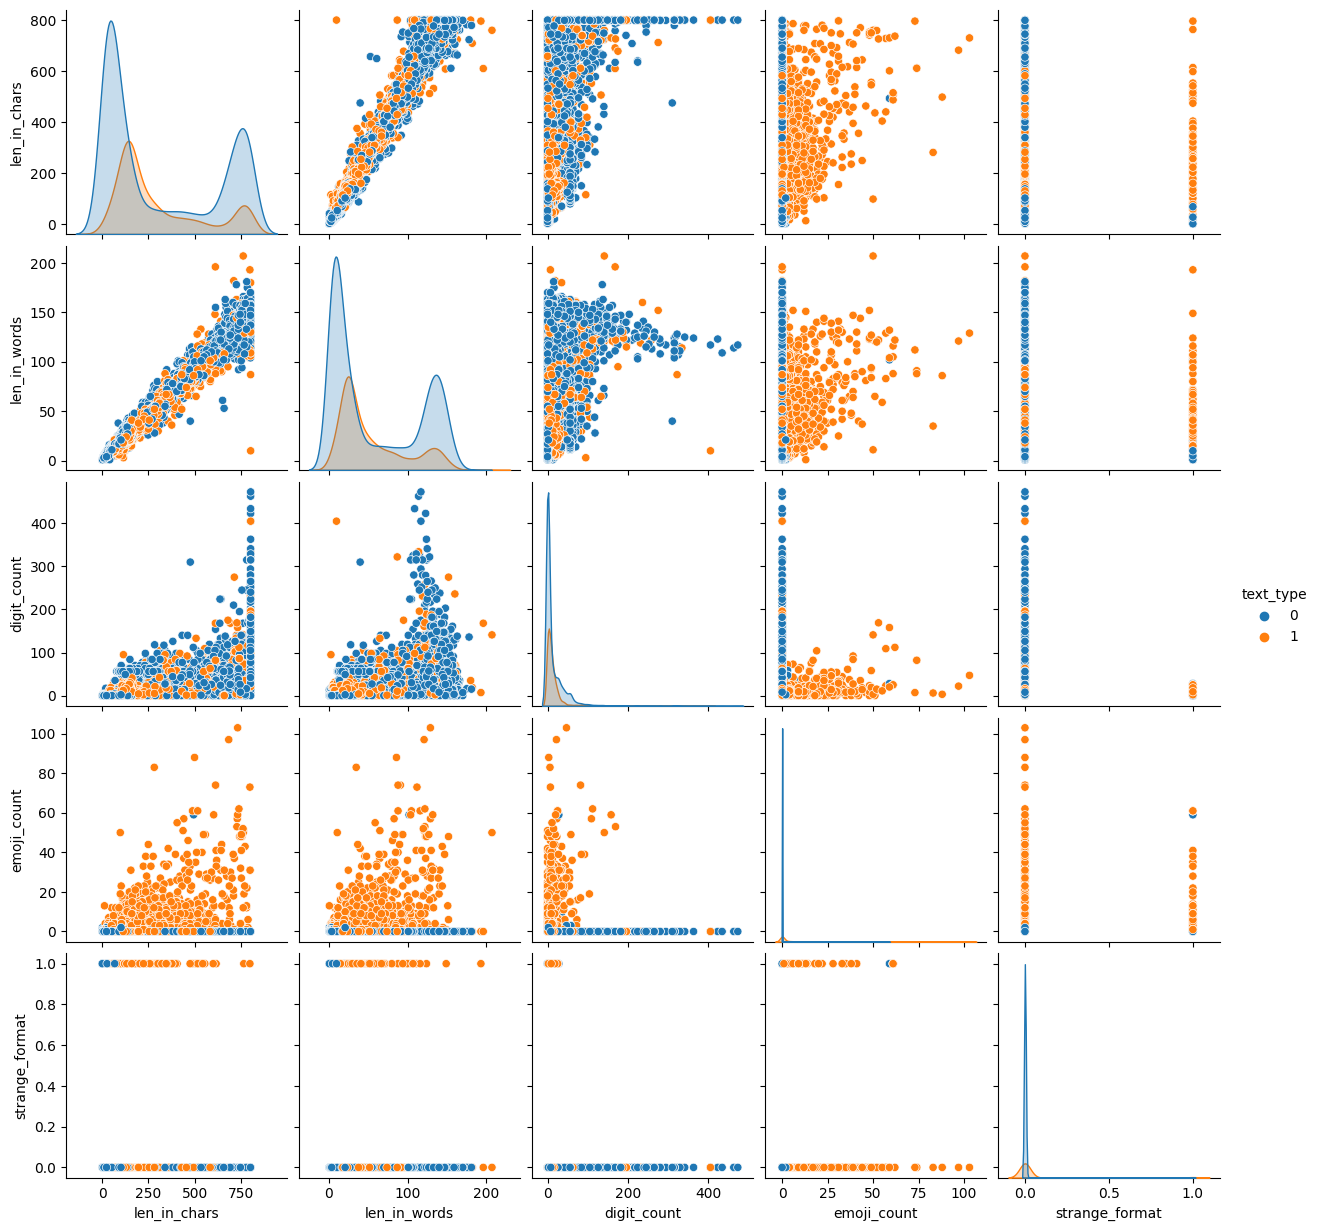

In [21]:
sns.pairplot(df_train, hue="text_type")

### Посмотрим, какие признаки коррелируют с таргетом

<Axes: >

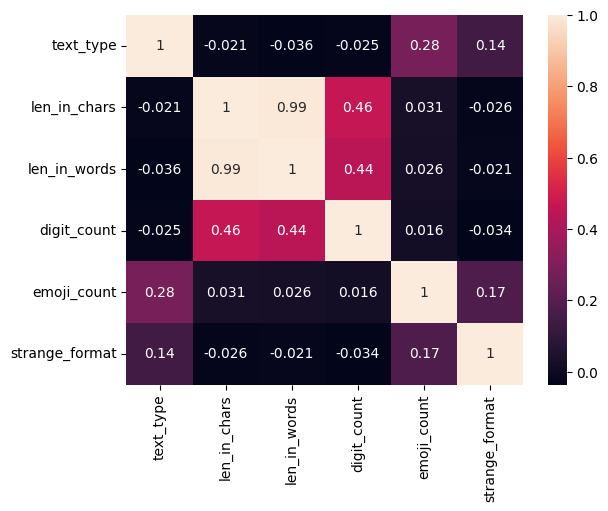

In [22]:
sns.heatmap(df_train[["text_type","len_in_chars","len_in_words","digit_count","emoji_count","strange_format"
                    ]].corr(), annot = True)

### emoji_count и strange_format достаточно сильно коррелируют с таргетом, построим на них бейслайн

# Baseline

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [24]:
y_pred = (df_train.emoji_count > 0) | df_train.strange_format # здесь вероятности принимают знначения только 0 и 1
y_true = df_train.text_type

### Есть подозрения, что этот метод даст очень хороший precision, так как в ham эмодзи почти не встречаются, recall будет небольшим, а roc auc хотя бы немного выше 0.5)))

In [25]:
print(f"precision: {precision_score(y_true, y_pred)}",
      f"recall: {recall_score(y_true, y_pred)}",
      f"f1 : {f1_score(y_true, y_pred)}",
      f"roc_auc: {roc_auc_score(y_true, y_pred)}",
      sep="\n")

precision: 0.9423611111111111
recall: 0.2821792472447494
f1 : 0.43430948951832293
roc_auc: 0.6374677000755078


# Векторизация текста
### Попробуем BoW, TF-IDF и word2vec те же методы попробуем применить после лемматизации

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler


import scipy
from tqdm.auto import tqdm

### Разобьем тренировачные данные на train и val, а потом поделим на текст и фичи, полученные "вручную"

In [27]:
X,y = df_train[["text","emoji_count","strange_format"]], df_train.text_type
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_train_extra = X_train.text, X_train[["emoji_count","strange_format"]]
X_val, X_val_extra = X_val.text, X_val[["emoji_count","strange_format"]]

In [28]:
BoWvec = CountVectorizer(min_df=3, tokenizer=nltk.word_tokenize)
X_train_Bow = BoWvec.fit_transform(X_train)
X_val_Bow = BoWvec.transform(X_val)
X_train_Bow.shape, X_val_Bow.shape

((11386, 12686), (4881, 12686))

In [29]:
TFIDFvec = TfidfVectorizer(min_df=3, tokenizer=nltk.word_tokenize)
X_train_TFIDF = TFIDFvec.fit_transform(X_train)
X_val_TFIDF = TFIDFvec.transform(X_val)
X_train_TFIDF.shape, X_val_TFIDF.shape

((11386, 12686), (4881, 12686))

In [30]:
vec_size = 256

sent = [nltk.word_tokenize(row) for row in X_train]

w2vmodel = Word2Vec(sentences=sent, vector_size=vec_size, window=5, min_count=3, workers=4)

In [31]:
def get_mean_w2v_vector(sentence):
    Sum = 0
    Count = 0

    words = nltk.word_tokenize(sentence)

    for w in words:
        if w in w2vmodel.wv:
            Sum += w2vmodel.wv[w]
            # Sum += glove_vectors[w]
            Count += 1

    if Count == 0:
        return np.zeros(vec_size)

    return Sum / Count

In [32]:
X_train_w2v = np.vstack(X_train.map(get_mean_w2v_vector))
X_val_w2v = np.vstack(X_val.map(get_mean_w2v_vector))
X_train_w2v.shape, X_val_w2v.shape 

((11386, 256), (4881, 256))

### Лемматизация

In [33]:
!python3 -m nltk.downloader wordnet
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

/opt/conda/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpor

In [34]:
wnl = WordNetLemmatizer()

In [35]:
def lemmatize(text):
    return ' '.join([wnl.lemmatize(word) for word in nltk.word_tokenize(text)])

In [36]:
X_train_lemm = X_train.map(lemmatize)
X_val_lemm = X_val.map(lemmatize)

In [37]:
BoWvec_lemm = CountVectorizer(min_df=3, tokenizer=nltk.word_tokenize)
X_train_Bow_lemm = BoWvec_lemm.fit_transform(X_train_lemm)
X_val_Bow_lemm = BoWvec_lemm.transform(X_val_lemm)

TFIDFvec_lemm = TfidfVectorizer(min_df=3, tokenizer=nltk.word_tokenize)
X_train_TFIDF_lemm = TFIDFvec_lemm.fit_transform(X_train_lemm)
X_val_TFIDF_lemm = TFIDFvec_lemm.transform(X_val_lemm)

sent_lemm = [nltk.word_tokenize(row) for row in X_train_lemm]
w2vmodel_lemm = Word2Vec(sentences=sent_lemm, vector_size=vec_size, window=5, min_count=3, workers=4)

X_train_w2v_lemm = np.vstack(X_train_lemm.map(get_mean_w2v_vector))
X_val_w2v_lemm = np.vstack(X_val_lemm.map(get_mean_w2v_vector))
X_train_Bow_lemm.shape, X_val_Bow_lemm.shape, X_train_TFIDF_lemm.shape, X_val_TFIDF_lemm.shape 

((11386, 11653), (4881, 11653), (11386, 11653), (4881, 11653))

# Обучение моделей

In [38]:
classifiers = {"KNN" : KNeighborsClassifier(n_jobs=4),
              "LogReg" : LogisticRegression(max_iter=9999, n_jobs=4),
              "NaiveBayes" : ComplementNB(),
              "LinSVM" : SVC(kernel="linear", probability=True)}

In [39]:
vectorizers = {"BoW" : (X_train_Bow, X_val_Bow),
              "TF-IDF" : (X_train_TFIDF, X_val_TFIDF),
               "Word2Vec": (X_train_w2v, X_val_w2v),
               "BoW_lemm" : (X_train_Bow_lemm, X_val_Bow_lemm),
              "TF-IDF_lemm" : (X_train_TFIDF_lemm, X_val_TFIDF_lemm),
               "Word2Vec_lemm": (X_train_w2v_lemm, X_val_w2v_lemm),
              }

In [40]:
results = {key:[] for key in vectorizers}

In [41]:
for vec_key in vectorizers:
    print(vec_key)
    for clf_key in tqdm(classifiers):
        print(clf_key)
        if "Word2Vec" in vec_key and clf_key == "NaiveBayes":
            clf = Pipeline([('scaler', MinMaxScaler()), ('NB', ComplementNB())]).fit(vectorizers[vec_key][0],y_train)
            #NB не работает с отрицательными значениями в w2v
        else:
            clf = classifiers[clf_key].fit(vectorizers[vec_key][0],y_train)
        print(f"Train: {roc_auc_score(y_train,clf.predict_proba(vectorizers[vec_key][0])[:, 1])}")
        score = roc_auc_score(y_val,clf.predict_proba(vectorizers[vec_key][1])[:, 1])
        print(f"Test: {score}")
        results[vec_key].append(score)

BoW


  0%|          | 0/4 [00:00<?, ?it/s]

KNN
Train: 0.9431983286973494
Test: 0.7974944062186037
LogReg
Train: 0.9991579907327887
Test: 0.9786851911892439
NaiveBayes
Train: 0.9868105590440628
Test: 0.9671385856839224
LinSVM
Train: 0.9992068736821483
Test: 0.9726806321073046
TF-IDF


  0%|          | 0/4 [00:00<?, ?it/s]

KNN
Train: 0.9940087080394411
Test: 0.7106668107640766
LogReg
Train: 0.9910809891069986
Test: 0.9760528117007097
NaiveBayes
Train: 0.9810005483213993
Test: 0.9607178452633981
LinSVM
Train: 0.9962790061128396
Test: 0.9811828796266276
Word2Vec


  0%|          | 0/4 [00:00<?, ?it/s]

KNN
Train: 0.980991741587079
Test: 0.939564445565202
LogReg
Train: 0.9092405644574174
Test: 0.9006455363825946
NaiveBayes
Train: 0.8109472649776168
Test: 0.792708971264575
LinSVM
Train: 0.9171716232602425
Test: 0.9073092410469478
BoW_lemm


  0%|          | 0/4 [00:00<?, ?it/s]

KNN
Train: 0.9452730392344845
Test: 0.7980997154076156
LogReg
Train: 0.9990716698727639
Test: 0.978947968826927
NaiveBayes
Train: 0.9857717731456584
Test: 0.9669788777213396
LinSVM
Train: 0.999063234730609
Test: 0.9729165916159322
TF-IDF_lemm


  0%|          | 0/4 [00:00<?, ?it/s]

KNN
Train: 0.9935428057824497
Test: 0.7150331624177944
LogReg
Train: 0.9910848165063023
Test: 0.9763207928559705
NaiveBayes
Train: 0.980251269879066
Test: 0.9609207824489354
LinSVM
Train: 0.9961773756556
Test: 0.9819198778374181
Word2Vec_lemm


  0%|          | 0/4 [00:00<?, ?it/s]

KNN
Train: 0.9809354825332359
Test: 0.9390894244509288
LogReg
Train: 0.909909300297898
Test: 0.9011371687260588
NaiveBayes
Train: 0.8109305619097815
Test: 0.7926218123451454
LinSVM
Train: 0.9186962287557043
Test: 0.9100040627464165


In [42]:
result_df = pd.DataFrame(data=results,index=classifiers.keys())
result_df.to_csv("roc_auc_scores.csv", index=True)
result_df

,BoW,TF-IDF,Word2Vec,BoW_lemm,TF-IDF_lemm,Word2Vec_lemm
KNN,0.797494,0.710667,0.939564,0.798100,0.715033,0.939089
LogReg,0.978685,0.976053,0.900646,0.978948,0.976321,0.901137
NaiveBayes,0.967139,0.960718,0.792709,0.966979,0.960921,0.792622
LinSVM,0.972681,0.981183,0.907309,0.972917,0.981920,0.910004


# Выводы

### Наилучшие разультаты показали логистическая регрессия и метод опорных векторов. Лемматизация для них увеличила скор только в 4 знаке после запятой, поэтому её применение не очень оправдано

In [43]:
final_vectorizer = TFIDFvec
final_model = classifiers["LinSVM"].fit(X_train_TFIDF,y_train)

# Скоринг тестовых данных

In [44]:
preds = final_model.predict_proba(final_vectorizer.transform(df_test.text))[:,1]

In [45]:
submit = df_test.copy()
submit["score"] = preds
submit.to_csv("scoring.csv",index=False)

In [46]:
submit[submit.score>0.99].sample(1).text.iloc[0]

'giveway time start now 👉👈 🙄 task watch this video and subscribe this channel and send ss to @arrowstuffsbot and message will deleted on 1000 pm so do fast winner will get one instagram account having 8k follower insta id is @dipanshushooter302 25th will win share this msg maximum'